## Combining AGN PSDs onto one plot

In [1]:
from analysis import *

import everest 

import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)
logging.getLogger("everest").setLevel(logging.WARNING)

import richardsplot
from matplotlib import colors

In [2]:
df = pd.read_csv("object_keys/c8_agn_w_redshift.csv")
campaign = 8

epics = np.array(df['EPIC ID'])

ERROR [everest.user.DownloadFile()]: Error code 0 for URL 'https://archive.stsci.edu/hlsps/everest/v2/c08/220100000/98775/hlsp_everest_k2_llc_220198775-c08_kepler_v2.0_lc.fits'
ERROR [everest.user.DownloadFile()]: Error code 0 for URL 'https://archive.stsci.edu/hlsps/everest/v2/c08/220100000/86429/hlsp_everest_k2_llc_220186429-c08_kepler_v2.0_lc.fits'
ERROR [everest.user.DownloadFile()]: Error code 0 for URL 'https://archive.stsci.edu/hlsps/everest/v2/c08/220100000/85497/hlsp_everest_k2_llc_220185497-c08_kepler_v2.0_lc.fits'


/home/rachel/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/rachel/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/rachel/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


NameError: name 'N' is not defined

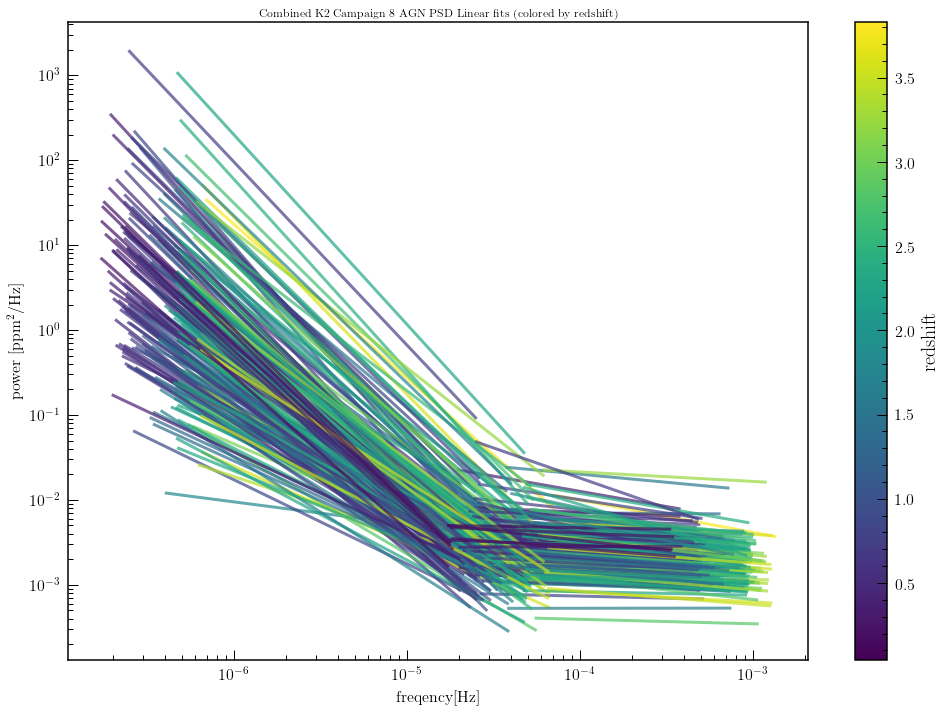

In [3]:
plt.figure(figsize=(14,10))

mags = np.array(df['ZSPEC'])
# creating colorscale based on magnitude
cmap = plt.cm.viridis
#cmap = plt.cm.inferno_r

norm = colors.Normalize(vmin=np.min(mags), vmax=np.max(mags))
cs=cmap(norm(mags))

# adding the colorbar on the side
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar  = plt.colorbar(sm)
cbar.set_label('redshift', fontsize=20)


m_arr = []
m_noise_arr = []
color_params = []
channels = []


for epic in epics[:]:
    
    
    try:
        # -----------------get EVEREST PLD-----------------
        lc = everest.Everest(epic, season=campaign, mission='k2')

        # -----------------do addtional cut and slope subtraction-----------------
        # put flux/cadences into an array
        # (there are 3852 cadences in a given 80 day campaign)
        cad = np.arange(3852+1)
        flux_pld = lc.flux

        # turning indices found to be "bad" into a boolen mask to apply
        mask = (np.isin(cad, np.concatenate([lc.nanmask, lc.badmask, lc.mask])))

        # interpolate the spurious cadences
        interped_vals = np.interp(cad[mask], cad[~mask], flux_pld[~mask])
        # replace spurious cadence values with the interpolated values
        flux_pld[mask] = interped_vals

        # 30 mintue intervals between cadences 
        cutoff_day = 3*24*2
        #cutoff = np.logical_and(cad>cutoff_day, cad<cad[-1]-5*cutoff_day)
        cutoff = cad>cutoff_day
        # finding linear fit 
        m,b = np.polyfit(cad[cutoff], flux_pld[cutoff], 1)

        # subtracting it
        flux_corrected = flux_pld[cutoff] - (m*cad[cutoff])

        # -----------------Calculate PSD-----------------
        freq, power = LS_PSD(lc.time[cutoff]*86400, flux_corrected, f = k2_freq)

        # get redshift and convert to rest frame
        z = df['ZSPEC'][df['EPIC ID']==epic].values[0]
        freq = freq*(1+z)

        # -----------------calculate slopes for above and below noise floor-----------------
        noise_floor_days = 5
        # noise floor are freqencies > X days, convert to Hz
        noise_floor_mask = freq>(2*np.pi/(noise_floor_days*86400))*(1+z)

        m, b = np.polyfit(np.log10(freq)[~noise_floor_mask], np.log10(power)[~noise_floor_mask], 1)
        m_noise, b_noise = np.polyfit(np.log10(freq)[noise_floor_mask], np.log10(power)[noise_floor_mask], 1)


        # -----------------plot on one PSD plot (line fits)
        # color by mag or reshift
        mag = df['ZSPEC'][df['EPIC ID']==epic].values[0]
        
        color_ = cmap(norm(mag))

        # plot
        plt.plot(freq[~noise_floor_mask], 10**(np.log10(freq[~noise_floor_mask])*m+b), linewidth=3, alpha = 0.7, color= color_)
        plt.plot(freq[noise_floor_mask], 10**(np.log10(freq[noise_floor_mask])*m_noise+b_noise), linewidth=3, alpha = 0.7, color=color_)
        
        m_arr.append(m)
        m_noise_arr.append(m_noise)
        color_params.append(mag)
        channels.append(df['CHANNEL'][df['EPIC ID']==epic].values[0])
        
    except:
        pass


plt.xscale('log')
plt.yscale('log')
plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("freqency[Hz]")
plt.title("Combined K2 Campaign 8 AGN PSD Linear fits (colored by redshift)")

plt.tight_layout()
#plt.savefig("/home/rachel/Research/K2/submit/PSD_combined_AGN_%s.png"%N)

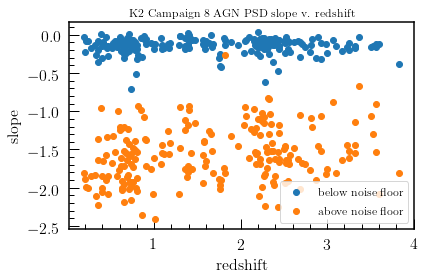

In [4]:
plt.plot(color_params, m_noise_arr, 'o', label="below noise floor")
plt.plot(color_params, m_arr, 'o', label="above noise floor")

plt.title("K2 Campaign 8 AGN PSD slope v. redshift")
plt.xlabel("redshift")
plt.ylabel("slope")
plt.legend()
plt.tight_layout()
#plt.savefig("/home/rachel/Research/K2/submit/PSD_slope_v_redshift_AGN_%s.png"%N)

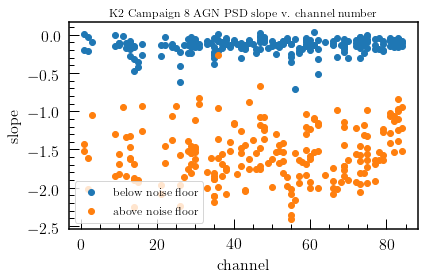

In [5]:
plt.plot(channels, m_noise_arr, 'o', label="below noise floor")
plt.plot(channels, m_arr, 'o', label="above noise floor")

plt.title("K2 Campaign 8 AGN PSD slope v. channel number")
plt.xlabel("channel")
plt.ylabel("slope")
plt.legend()
plt.tight_layout()
#plt.savefig("/home/rachel/Research/K2/submit/PSD_slope_v_redshift_AGN_%s.png"%N)

-1.5850319546606244

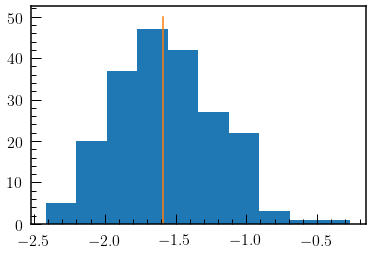

In [6]:
plt.hist(m_arr)
plt.plot(np.ones(2)*np.median(m_arr), [0,50],'-')
np.median(m_arr[m_arr<-0.5])



All the slopes are around -1.5

---
## Try the same with the Ed Shaya Galaxies (K2 Campaign 8)

In [7]:
df_sh = pd.read_csv("object_keys/c8_shaya.csv")

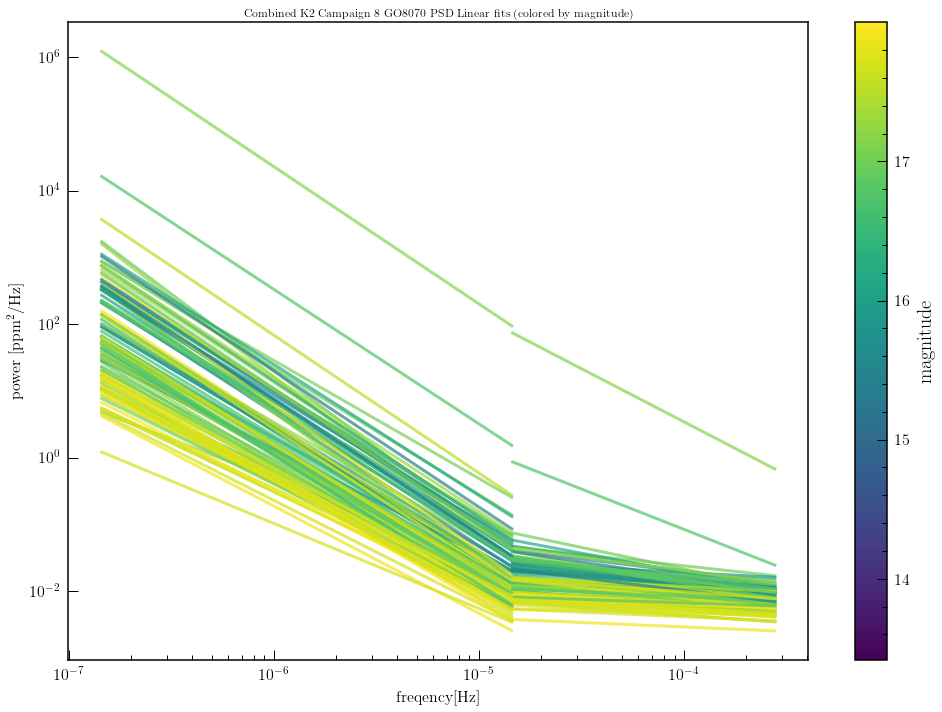

In [8]:
plt.figure(figsize=(14,10))

mags = np.array(df_sh['magnitude'])
# creating colorscale based on magnitude
cmap = plt.cm.viridis
#cmap = plt.cm.inferno_r

norm = colors.Normalize(vmin=np.min(mags), vmax=np.max(mags))
cs=cmap(norm(mags))

# adding the colorbar on the side
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar  = plt.colorbar(sm)
cbar.set_label('magnitude', fontsize=20)


# for plottign after
m_arr_sh = []
m_noise_arr_sh = []
color_params_sh = []
channels_sh = []


for epic in np.array(df_sh['EPIC ID'])[:100]:
    
    # -----------------get EVEREST PLD-----------------
    lc = everest.nPLD(epic, season=campaign, mission='k2')

    # -----------------do addtional cut and slope subtraction-----------------
    # put flux/cadences into an array
    # (there are 3852 cadences in a given 80 day campaign)
    cad = np.arange(3852+1)
    flux_pld = lc.flux

    # turning indices found to be "bad" into a boolen mask to apply
    mask = (np.isin(cad, np.concatenate([lc.nanmask, lc.badmask, lc.mask])))

    # interpolate the spurious cadences
    interped_vals = np.interp(cad[mask], cad[~mask], flux_pld[~mask])
    # replace spurious cadence values with the interpolated values
    flux_pld[mask] = interped_vals

    # 30 mintue intervals between cadences 
    cutoff_day = 3*24*2
    #cutoff = np.logical_and(cad>cutoff_day, cad<cad[-1]-5*cutoff_day)
    cutoff = cad>cutoff_day
    # finding linear fit 
    m,b = np.polyfit(cad[cutoff], flux_pld[cutoff], 1)

    # subtracting it
    flux_corrected = flux_pld[cutoff] - (m*cad[cutoff])

    # -----------------Calculate PSD-----------------
    freq, power = LS_PSD(lc.time[cutoff]*86400, flux_corrected, f = k2_freq)

    # -----------------calculate slopes for above and below noise floor-----------------
    noise_floor_days = 5
    # noise floor are freqencies > X days, convert to Hz
    noise_floor_mask = freq>(2*np.pi/(noise_floor_days*86400))

    m, b = np.polyfit(np.log10(freq)[~noise_floor_mask], np.log10(power)[~noise_floor_mask], 1)
    m_noise, b_noise = np.polyfit(np.log10(freq)[noise_floor_mask], np.log10(power)[noise_floor_mask], 1)


    # -----------------plot on one PSD plot (line fits)
    # color by mag or reshift
    mag = df_sh['magnitude'][df_sh['EPIC ID']==epic].values[0]

    color_ = cmap(norm(mag))

    # plot
    plt.plot(freq[~noise_floor_mask], 10**(np.log10(freq[~noise_floor_mask])*m+b), linewidth=3, alpha = 0.7, color= color_)
    plt.plot(freq[noise_floor_mask], 10**(np.log10(freq[noise_floor_mask])*m_noise+b_noise), linewidth=3, alpha = 0.7, color=color_)

    m_arr_sh.append(m)
    m_noise_arr_sh.append(m_noise)
    color_params_sh.append(mag)
    channels_sh.append(df_sh['CHANNEL'][df_sh['EPIC ID']==epic].values[0])


plt.xscale('log')
plt.yscale('log')
plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("freqency[Hz]")
plt.title("Combined K2 Campaign 8 GO8070 PSD Linear fits (colored by magnitude)")

plt.tight_layout()
#plt.savefig("/home/rachel/Research/K2/submit/PSD_combined_AGN_%s.png"%N)

-1.8436471631886269

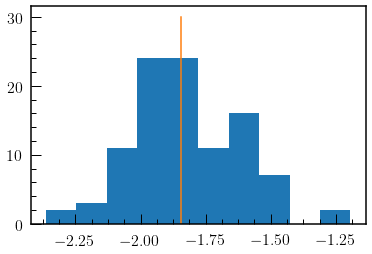

In [9]:
plt.hist(m_arr_sh)
plt.plot(np.ones(2)*np.median(m_arr_sh), [0,30],'-')
np.median(m_arr_sh)

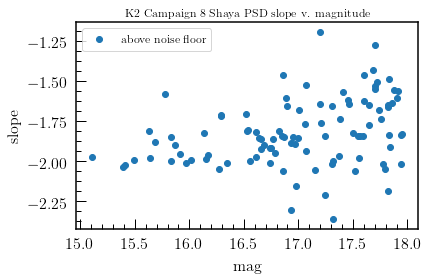

In [10]:
#plt.plot(color_params_sh, m_noise_arr_sh, 'o', label="below noise floor")
plt.plot(color_params_sh, m_arr_sh, 'o', label="above noise floor")

plt.title("K2 Campaign 8 Shaya PSD slope v. magnitude")
plt.xlabel("mag")
plt.ylabel("slope")
plt.legend()
plt.tight_layout()
#plt.savefig("/home/rachel/Research/K2/submit/PSD_slope_v_redshift_AGN_%s.png"%N)